<a href="https://colab.research.google.com/github/PTrillat/Reinforcement-Learning/blob/main/Pendule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Le simulateur du pendule inversé
Équations de Lagrange + RK4 pour l'intégration numérique

In [241]:
import numpy as np
import numpy.random as random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import count
from collections import namedtuple, deque

class Pendule(object):
  """
  On travail avec des grandeurs adimensionnées pour généraliser l'apprentissage
  Grandeures de référence:
   - m (masse du pendule)       [m] = kg
   - l (longueur du pendule)    [l] = m
   - T (durée de la simulation) [T] = s
  Grandeures standardisées:
   - g (accélération de gravité) remplacé par gT²/l   nomé g
   - C (couple du moteur)        remplacé par CT²/ml² nomé C
   - dt (pas de temps)           remplacé par dt/T    nomé dh
   - dθ/dt (rotation)            remplacé par dθ/dh   nomé dX
  """
  def __init__(self, dh, g, θ, dθ):
    self.const = dh, g
    self.J = 0.0
    self.X = θ
    self.dX = dθ
  
  @staticmethod
  def Variation(dh, g, θ, dθ, C):
    return np.cos(θ)*dh-0.1*C*dθ, (g*np.sin(θ) + C)*dh*dh
  
  def Simpson(self, C=0.0):
    X0 = self.X
    dX0 = self.dX
    dJ0, ddX0 = self.Variation(*self.const, X0, dX0, C)
    X1 = X0 + dX0/2
    dX1 = dX0 + ddX0/2
    dJ1, ddX1 = self.Variation(*self.const, X1, dX1, C)
    X2 = X0 + dX1/2
    dX2 = dX0 + ddX1/2
    dJ2, ddX2 = self.Variation(*self.const, X2, dX2, C)
    X3 = X0 + dX2
    dX3 = dX0 + dX2
    dJ3, ddX3 = self.Variation(*self.const, X3, dX3, C)
    self.J  += ( dJ0 + 2* dJ1 + 2* dJ2 +  dJ3)/6
    self.X  += ( dX0 + 2* dX1 + 2* dX2 +  dX3)/6
    self.dX += (ddX0 + 2*ddX1 + 2*ddX2 + ddX3)/6


class Chariot(object):
  """
  On travail avec des grandeurs adimensionnées pour généraliser l'apprentissage
  Grandeures de référence:
   - m (masse du pendule)       [m] = kg
   - l (longueur du pendule)    [l] = m
   - T (durée de la simulation) [T] = s
  Grandeures standardisées:
   - g (accélération de gravité) remplacé par gT²/l   nomé g
   - F (force du moteur)         remplacé par FT²/ml  nomé F
   - t (temps)                   remplacé par t/T     nomé h
   - M (masse du chariot)        remplacé par M/m     nomé µ
   - x (position)                remplacé par x/l     nomé x
   - dθ/dt (rotation)            remplacé par dθ/dh   nomé dθ
  """
  def __init__(self, dh, µ, g, x, θ, dx, dθ):
    self.const = (dh, µ, g)
    self.J  = 0.0
    self.X  = np.array([x, θ])
    self.dX = np.array([dx, dθ])
  
  @staticmethod
  def Variation(dh, µ, g, x, θ, dx, dθ, F):
    s, c = np.sin(θ), np.cos(θ)
    A, B = F*dh*dh + s*dθ*dθ, g*s*dh*dh
    return np.cos(θ)*dh-0.9*F*dx, np.array([A - c*B, c*A + (µ+1)*B])/(µ+s*s)

  def Simpson(self, F=0.0):
    X0 = self.X
    dX0 = self.dX
    dJ0, ddX0 = self.Variation(*self.const, *X0, *dX0, F)
    X1 = X0 + dX0/2
    dX1 = dX0 + ddX0/2
    dJ1, ddX1 = self.Variation(*self.const, *X1, *dX1, F)
    X2 = X0 + dX1/2
    dX2 = dX0 + ddX1/2
    dJ2, ddX2 = self.Variation(*self.const, *X2, *dX2, F)
    X3 = X0 + dX2
    dX3 = dX0 + dX2
    dJ3, ddX3 = self.Variation(*self.const, *X3, *dX3, F)
    self.J  += ( dJ0 + 2* dJ1 + 2* dJ2 +  dJ3)/6
    self.X  += ( dX0 + 2* dX1 + 2* dX2 +  dX3)/6
    self.dX += (ddX0 + 2*ddX1 + 2*ddX2 + ddX3)/6

Animation du pendule et du chariot pour vérifier

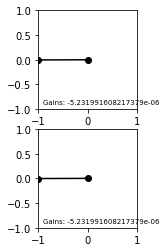

In [242]:
# Paramètres pour l'animation
T, f, l = 5.0, 50, 0.5 # s, Hz = 1/dt, m

dh = 1.0/(f*T)
pendule = Pendule(dh,      9.81*T*T/l,      -np.pi*0.5,      0.0)
chariot = Chariot(dh, 1.0, 9.81*T*T/l, 0.0, -np.pi*0.5, 0.0, 0.0)

fig, (axe_pendule, axe_chariot) = plt.subplots(2,1)

axe_pendule.set_xlim(-1,1)
axe_pendule.set_ylim(-1,1)
axe_pendule.set_aspect('equal', 'box')
barre_pendule, = axe_pendule.plot([], [], 'ko-')
texte_pendule  = axe_pendule.text(-0.9, -0.9, '', fontsize=7)

axe_chariot.set_xlim(-1,1)
axe_chariot.set_ylim(-1,1)
axe_chariot.set_aspect('equal', 'box')
barre_chariot, = axe_chariot.plot([], [], 'ko-')
texte_chariot  = axe_chariot.text(-0.9, -0.9, '', fontsize=7)

def animate(i):
  dθ = pendule.dX
  pendule.Simpson(0.0)
  θ = pendule.X
  barre_pendule.set_data([0, np.sin(θ)], [0, np.cos(θ)])
  texte_pendule.set_text('Gains: '+str(pendule.J))
  dx, dθ = chariot.dX
  chariot.Simpson(0.0)
  x, θ = chariot.X
  barre_chariot.set_data([x, x+np.sin(θ)], [0, np.cos(θ)])
  texte_chariot.set_text('Gains: '+str(chariot.J))
  return barre_pendule, barre_chariot
 
ani = animation.FuncAnimation(fig, animate, frames=int(f*T), blit=True, interval=int(1000/f), repeat=False)

Et on lance l'animation

In [243]:
from matplotlib import rc
rc('animation', html='html5')

ani

# Les réseaux de neurones

In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N = 5

class Pi(nn.Module):
    def __init__(self, long_etat, long_acti):
        super(Pi, self).__init__()
        self.long_etat = long_etat
        self.long_acti = long_acti
        self.couche1 = nn.Linear(  long_etat, N*long_etat)
        self.couche2 = nn.Linear(N*long_etat, N*long_acti)
        self.couche3 = nn.Linear(N*long_acti,   long_acti)

    def forward(self, etat):
        temp = F.relu(self.couche1(etat))
        temp = F.relu(self.couche2(temp))
        temp = F.atan(self.couche3(temp))
        return temp


class Qu(nn.Module):
    def __init__(self, long_etat, long_acti):
        super(Qu, self).__init__()
        self.long_entree = long_etat * long_acti
        self.couche1 = nn.Linear(  long_entree, N*long_entree)
        self.couche2 = nn.Linear(N*long_entree, N)
        self.couche3 = nn.Linear(N, 1)

    def forward(self, etat, action):
        temp = F.relu(self.couche1(torch.cat((etat, action), 1)))
        temp = F.relu(self.couche2(temp))
        temp = F.relu(self.couche3(temp))
        return temp

# L'agent

In [245]:
class Mario_Pendule(object):
  def __init__(self, T, f, l):
    dh = 1.0/(f*T)
    self.pendule = Pendule(dh, 9.81*T*T/l, -np.pi, 0.0)
    self.pi = Pi(2, 1)
    self.qu = Qu(2, 1)
    self.N = int(f*T)
  
  def Episode(self):
    

SyntaxError: ignored